In [1]:
#platnost dat
#záporné zisky
#nulové zisky
#směny
#co bylo ve fabrice
#leštění #todo

In [2]:
import h2o
import pandas
import pprint
import operator
import matplotlib
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from tabulate import tabulate
import pandas as pd
import matplotlib.dates as md
import matplotlib.ticker as tkr
import datetime as dt
from datetime import timedelta, date
import numpy as np
interactive = True
if not interactive: matplotlib.use('Agg', warn=False)
import matplotlib.pyplot as plt
import sys
import graphviz
plt.close('all')
sys.version_info

from config import COMPANY_FOLDER

In [3]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) Client VM (build 25.151-b12, mixed mode)


c:\programdata\miniconda3\lib\site-packages\h2o\backend\server.py:258: UserWarning:   You have a 32-bit version of Java. H2O works best with 64-bit Java.
  Please download the latest 64-bit Java SE JDK from Oracle.

  warn("  You have a 32-bit version of Java. H2O works best with 64-bit Java.\n"


  Starting server from c:\programdata\miniconda3\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\michal\AppData\Local\Temp\tmp8uyt0i53
  JVM stdout: C:\Users\michal\AppData\Local\Temp\tmp8uyt0i53\h2o_michal_started_from_python.out
  JVM stderr: C:\Users\michal\AppData\Local\Temp\tmp8uyt0i53\h2o_michal_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


--------------------------  -------------------------------
H2O cluster uptime:         03 secs
H2O cluster version:        3.14.0.6
H2O cluster version age:    3 months and 14 days !!!
H2O cluster name:           H2O_from_python_michal_3o98a7
H2O cluster total nodes:    1
H2O cluster free memory:    247.5 Mb
H2O cluster total cores:    4
H2O cluster allowed cores:  4
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Algos, AutoML, Core V3, Core V4
Python version:             3.6.2 final
--------------------------  -------------------------------

In [4]:
# vrací nekonečný seznam nul, vhodné pro zip
def zeros():
    while True:
        yield 0


def plot_hist(data, column, ranges_to, ranges_from = zeros(), xlabel=""):
    x = data[column].as_data_frame(use_pandas=True)
    
    for t, f in zip(ranges_to, ranges_from):
        x.hist(bins=25, range=[f,t])
        plt.xlabel(xlabel)
        plt.show()
    
#rozdělí data podle sloupce a definovaných intervalů
def split_to_level(data, column, level = [1000, 2000]):
    data[column + "_l0"] = data[column] <= level[0]
    for i, it in enumerate(level[:-1]):
        data[column + "_l" + str(i + 1)] = (data[column] > level[i]) * (data[column] <= level[i + 1])
        
    data[column + "_l" + str(len(level))] = data[column] > level[len(level)-1]

#    
def agregate(data, column, columns = None):
    
    if not columns:
        column_name = column + "_l"
        columns = list(filter(lambda x: column_name in x, data.names))
        #print(columns)
        
    gd = data.group_by(by=["week","year"])
    [gd.sum(x) for x in columns]
    df = gd.get_frame()
        
    #print(df.names)
    #print(columns)
        
    df[column + "_sum_all"] = df["sum_" + columns[-1]]
    
    for c in columns[:-1]:
        #print(column + "_sum_all", "sum_" + c)
        df[column + "_sum_all"] = df[column + "_sum_all"] + df["sum_" + c]
        
    for c in columns:
        df[c + "_ratio"] = df["sum_" + c] / df[column + "_sum_all"]
        
    return df

#vytiskne roční graf pro data rozdělená do skupin
def plot_year(data, column, columns = None, year=2014, ratio = True):
    df_year = df[df["year"]==year]
    
    if not columns:
        column_name = column + "_l"
        columns = list(filter(lambda x: column_name in x, data.names))
        if ratio:
            columns = list(filter(lambda x: "ratio" in x, columns))
        else:
            columns = list(filter(lambda x: "sum" in x, columns))
            
    columns = sorted(columns)

    x = np.arange(df_year.dim[0])
    
    y = df_year[columns].as_data_frame(use_pandas=True)
    
    fig, ax = plt.subplots()
    ax.stackplot(x, y.transpose())
    ax.set_title(column)
    plt.legend(columns, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel('week', fontsize=10)
    plt.show()
    
    fig, ax = plt.subplots()
    ax.set_title(column)
    [ax.plot(x, y[it], label=lab) for it, lab in zip(y, columns)]
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.xlabel('week', fontsize=10)
    plt.show()

In [5]:
# Načtení csv dat pro zakázky
# Vymazání dat které nejsou kompletní
company = COMPANY_FOLDER + "/"


name = company + "zakazky_h2o.csv"
print("Import and Parse data")
data = h2o.import_file(path=name, col_types=2*["string"] + ["numeric"] * 6 + ["string"] + ["numeric"] + 4 * ["time"] + ["numeric"] *2)
data["id"] = data["id"].asfactor()
data.describe()

print(data["ukonceni_X"].as_data_frame(use_pandas=True).shape)
print(data["zadani_X"].as_data_frame(use_pandas=True).shape)

#A = [dt.date.fromtimestamp(int(d[1])/1000) for d in data["ukonceni_X"].as_data_frame(use_pandas=True).iterrows()]
#B = [dt.date.fromtimestamp(int(d[1])/1000) for d in data["zadani_X"].as_data_frame(use_pandas=True).iterrows()]

#print(np.busday_count(B, A))


data["dobaKus"] = ((data["ukonceni_X"] - data["zadani_X"]) / data["kusy_odved"]) / (1000 * 60)
#data["dobaKus"] = data["dobaKus"].floor()
data["dobaZakazka"] = ((data["ukonceni_X"] - data["zadani_X"])) / (1000 * 60) 
data["product_name"] = data["Nazev1"].asfactor()
data["week"] = data["zadani_X"].week()
data["year"] = data["zadani_X"].year()
#data.describe()
dataNonEmpty = data[data["kusy_odved"] > 0]
#dataNonEmpty["dobaKus"].describe()

Import and Parse data
Parse progress: |█████████████████████████████████████████████████████████| 100%
Rows:33008
Cols:16




id order_id Rada StavPrikazu IDTabKmen IDZakazka kusy_ciste kusy_zad Nazev1 CisloZakazky plan_zadani plan_ukonceni zadani_X ukonceni_X kusy_odved kusy_zmet 
 
 
 type enum string int int int int int int string int time time time time int int 
 mins NaN 1.0 10.0 35801.0 1.0 1.0 1.0 NaN 0.0 1260921600000.0 1260921600000.0 1265241600000.0 1266451200000.0 0.0 0.0 
 mean NaN 1.0049987881725642 59.08719098400389 45960.542626030045 18946.88175593796 163.32637542413948 163.37975642268535 NaN 2054648515.6026728 1389629467930.667 1398475818592.4749 1389916000708.331 1391121769028.8062 119.69571013087733 1.7711463887542414 
 maxs NaN 3.0 60.0 62943.0 37073.0 1000000.0 1000000.0 NaN 48000000023.0 1495756800000.0 190654214400000.0 1489708800000.0 1489708800000.0 23900.0 1100.0 
 sigma NaN 0.09910301498310585 5.43666052636338 9175.782233702363 10726.239328118663 5515.939068093412 5515.952736273849 NaN 2379493397.9040794 65173833154.822136 1043778536482.9753 64912226237.65675 64164360128.69591 344.26690120777306 16.950730697508785 
 zeros 0 0 0 0 0 0 0 0 1 0 0 0 0 2525 27318 
 missing 0 0 0 0 0 0 0 0 0 1271 0 0 255 862 0 0 
 0 1500602926040 1053 1.0 60.0 35801.0 1580.0 199.0 199.0 Universalteller 10cm 45070279.0 2010-05-31 00:00:00 2010-05-31 00:00:00 2010-06-16 00:00:00 2010-07-30 00:00:00 199.0 0.0 
 1 1500602926040 1056 1.0 60.0 35801.0 1564.0 100.0 100.0 Universalteller 10cm 45070346.0 2010-06-04 00:00:00 2010-06-04 00:00:00 2010-08-04 00:00:00 2010-08-13 00:00:00 100.0 0.0 
 2 1500602926040 1298 1.0 60.0 35801.0 1667.0 100.0 100.0 Universalteller 10cm 45070594.0 2010-06-09 00:00:00 2010-06-09 00:00:00 2010-08-04 00:00:00 2010-09-06 00:00:00 92.0 1.0 
 3 1500602926040 1697 1.0 60.0 35801.0 2049.0 100.0 100.0 Universalteller 10cm 45071431.0 2010-07-12 00:00:00 2010-07-12 00:00:00 2010-08-06 00:00:00 2010-09-14 00:00:00 92.0 2.0 
 4 1500602926040 4322 1.0 60.0 35801.0 4655.0 100.0 100.0 Universalteller 10cm 45076368.0 2011-01-12 00:00:00 2011-02-22 00:00:00 2011-01-12 00:00:00 2011-01-28 00:00:00 100.0 0.0 
 5 9990603156040 1813 1.0 60.0 35802.0 2248.0 100.0 100.0 Beilagenschale 45071938.0 2010-07-29 00:00:00 2010-07-29 00:00:00 2010-07-27 00:00:00 2010-09-14 00:00:00 99.0 1.0 
 6 9990603156040 3635 1.0 60.0 35802.0 3995.0 100.0 100.0 Beilagenschale 45074918.0 2010-10-29 00:00:00 2011-01-07 00:00:00 2010-11-26 00:00:00 2011-01-11 00:00:00 100.0 0.0 
 7 9990603156040 6126 1.0 60.0 35802.0 6473.0 100.0 100.0 Beilagenschale 45079927.0 2011-06-23 00:00:00 2011-08-05 00:00:00 2011-06-23 00:00:00 2011-07-15 00:00:00 100.0 0.0 
 8 9990603156040 10022 1.0 60.0 35802.0 10683.0 50.0 50.0 Beilagenschale 45087631.0 2012-08-01 00:00:00 2012-09-03 00:00:00 2012-08-01 00:00:00 2012-09-13 00:00:00 48.0 2.0 
 9 9990603156040 12878 1.0 60.0 35802.0 13701.0 52.0 52.0 Beilagenschale 45093155.0 2013-05-06 00:00:00 2013-05-27 00:00:00 2013-05-07 00:00:00 2013-05-31 00:00:00 48.0 4.0

(33008, 1)
(33008, 1)


In [6]:
#Načtení dat a předzpracování
# asfactor je důležité pro groupby, protože nelze dělat group pro string.
# v databázi mají id jako string, nechávám jej jako string, jinak bych musel řešit dopisování nul.

# třetina skladových cen je nulová

name_stock_price = company + "stock_price.csv"

print("Import and Parse data")
stock_price = h2o.import_file(path=name_stock_price, col_types=["string"] + ["numeric"], sep=",")
stock_price["id"] = stock_price["id"].asfactor()
stock_price["sell_price"] = 0
stock_price["margin"] = stock_price["sell_price"] - stock_price["manufacture_cost"]
stock_price.describe()


Import and Parse data
Parse progress: |█████████████████████████████████████████████████████████| 100%
Rows:60566
Cols:4




id manufacture_cost sell_price margin 
 
 
 type enum real int real 
 mins -101.44 0.0 -188258.46 
 mean 747.2871950631056 0.0 -747.2871950631056 
 maxs 188258.46 0.0 101.44 
 sigma 3110.9420766680296 0.0 3110.9420766680296 
 zeros 6477 60566 6477 
 missing 0 0 0 0 
 0 1000121048040 8.79 0.0 -8.79 
 1 1000121048040 8.75 0.0 -8.75 
 2 1000185628491 38.01 0.0 -38.01 
 3 1000185628491 45.13 0.0 -45.13 
 4 1000185628491 45.52 0.0 -45.52 
 5 1000185628691 33.48 0.0 -33.48 
 6 1000185628691 39.02 0.0 -39.02 
 7 1000185628691 39.26 0.0 -39.26 
 8 1000362991001 198.52 0.0 -198.52 
 9 1000362991001 219.4 0.0 -219.4

In [7]:
#spocitat zisky pro jednotlive vyrobky za rok
groupedData = dataNonEmpty.group_by("id")
groupedData.sum("kusy_odved", na="ignore")
countOfProductByType = groupedData.get_frame()
stock_price2 = countOfProductByType.merge(stock_price)
stock_price2["margin_year"] = stock_price2["sum_kusy_odved"] * stock_price2["margin"]
print((stock_price["id"] == "3322921000").sum())

0.0


In [8]:
split_to_level(stock_price2 ,"sell_price", [300,900])
split_to_level(stock_price2, "margin", [30,200])
split_to_level(stock_price2 ,"manufacture_cost", [150,700])
#stock_price.describe()
#dataNonEmpty.describe()
#print(stock_price.names)
#print(dataNonEmpty.names)
dd = stock_price2.merge(dataNonEmpty)
split_to_level(dd, "margin_year", [0.0 * 387497, 0.2 * 387497, 1 * 387497])
#dd["test"] = dd["year_margin_l0"] + dd["year_margin_l1"] + dd["year_margin_l2"]
dd.describe()

Rows:30483
Cols:39




id order_id Rada StavPrikazu IDTabKmen IDZakazka kusy_ciste kusy_zad Nazev1 CisloZakazky plan_zadani plan_ukonceni zadani_X ukonceni_X kusy_odved kusy_zmet dobaKus dobaZakazka product_name week year manufacture_cost sell_price margin sum_kusy_odved margin_year sell_price_l0 sell_price_l1 sell_price_l2 margin_l0 margin_l1 margin_l2 manufacture_cost_l0 manufacture_cost_l1 manufacture_cost_l2 margin_year_l0 margin_year_l1 margin_year_l2 margin_year_l3 
 
 
 type enum string int int int int int int string int time time time time int int real int enum int int real int real int real int int int int int int int int int int int int int 
 mins NaN 1.0 30.0 35801.0 139.0 1.0 1.0 NaN 9371.0 1260921600000.0 1260921600000.0 1265328000000.0 1266451200000.0 1.0 0.0 0.0 0.0 1.0 2010.0 -0.47 0.0 -48563.05 1.0 -32971316.36 1.0 0.0 0.0 1.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
 mean NaN 1.0009841551028442 59.82678870189941 45759.447331299416 18716.24062592264 133.4650132860939 133.5175999737559 NaN 2029250311.2779045 1388466680715.0059 1397817525964.7268 1389508410274.5798 1392006207169.214 129.61047141029422 1.7251910901158023 2150.731548535452 47952.63574064312 24.763212282255683 2013.5698258045463 943.0303112670997 0.0 -943.0303112670997 3694.0891644523185 -1237453.838629442 1.0 0.0 0.0 1.0 0.0 0.0 0.292786143096152 0.423449135583768 0.28376472132008007 0.9997047534691468 0.0002952465308532625 0.0 0.0 
 maxs NaN 3.0 60.0 62867.0 36990.0 24000.0 24000.0 NaN 48000000023.0 1489481917173.0 190654214400000.0 1489449600000.0 1489708800000.0 23900.0 945.0 512160.0 2322720.0 52.0 2017.0 48563.05 0.0 0.47 153194.0 1135.52 1.0 0.0 0.0 1.0 0.0 0.0 1.0 1.0 1.0 1.0 1.0 0.0 0.0 
 sigma NaN 0.04435545271459334 2.0626421478158763 9110.2649883453 10460.178444347539 365.4128828377457 365.6367721845443 NaN 2387468910.32396 63723777329.4417 1085904908358.1781 63748571925.71847 63684138527.37799 356.4439240663109 14.832077284026777 7796.735603696102 65768.21694625227 14.718027344849443 2.0475942968599936 2171.5664663171488 0.0 2171.5664663171488 11055.484685342135 2767931.4674247038 0.0 0.0 0.0 0.0 0.0 0.0 0.4550485803161039 0.4941133214890675 0.45083142289697503 0.01718048437646498 0.017180484376464984 0.0 0.0 
 zeros 0 0 0 0 0 0 0 0 0 0 0 0 0 0 24941 311 311 0 0 1065 30483 1065 0 1065 0 30483 30483 0 30483 30483 21558 17575 21833 9 30474 30483 30483 
 missing 0 0 0 0 0 0 0 0 0 1178 0 0 0 131 0 0 131 131 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 
 0 1500602926040 1053 1.0 60.0 35801.0 1580.0 199.0 199.0 Universalteller 10cm 45070279.0 2010-05-31 00:00:00 2010-05-31 00:00:00 2010-06-16 00:00:00 2010-07-30 00:00:00 199.0 0.0 318.39195979899495 63360.0 Universalteller 10cm 24.0 2010.0 134.53 0.0 -134.53 583.0 -78430.99 1.0 0.0 0.0 1.0 0.0 0.0 1.0 0.0 0.0 1.0 0.0 0.0 0.0 
 1 1500602926040 1056 1.0 60.0 35801.0 1564.0 100.0 100.0 Universalteller 10cm 45070346.0 2010-06-04 00:00:00 2010-06-04 00:00:00 2010-08-04 00:00:00 2010-08-13 00:00:00 100.0 0.0 129.6 12960.0 Universalteller 10cm 31.0 2010.0 134.53 0.0 -134.53 583.0 -78430.99 1.0 0.0 0.0 1.0 0.0 0.0 1.0 0.0 0.0 1.0 0.0 0.0 0.0 
 2 1500602926040 1298 1.0 60.0 35801.0 1667.0 100.0 100.0 Universalteller 10cm 45070594.0 2010-06-09 00:00:00 2010-06-09 00:00:00 2010-08-04 00:00:00 2010-09-06 00:00:00 92.0 1.0 516.5217391304348 47520.0 Universalteller 10cm 31.0 2010.0 134.53 0.0 -134.53 583.0 -78430.99 1.0 0.0 0.0 1.0 0.0 0.0 1.0 0.0 0.0 1.0 0.0 0.0 0.0 
 3 1500602926040 1697 1.0 60.0 35801.0 2049.0 100.0 100.0 Universalteller 10cm 45071431.0 2010-07-12 00:00:00 2010-07-12 00:00:00 2010-08-06 00:00:00 2010-09-14 00:00:00 92.0 2.0 610.4347826086957 56160.0 Universalteller 10cm 31.0 2010.0 134.53 0.0 -134.53 583.0 -78430.99 1.0 0.0 0.0 1.0 0.0 0.0 1.0 0.0 0.0 1.0 0.0 0.0 0.0 
 4 1500602926040 4322 1.0 60.0 35801.0 4655.0 100.0 100.0 Universalteller 10cm 45076368.0 2011-01-12 00:00:00 2011-02-22 00:00:00 2011-01-12 00:00:00 2011-01-28 00:00:00 100.0 0.0 230.4 23040.0 Universalteller 10cm 2.0 2011.0 134.53 0.0 -134.53 583.0 

In [9]:
#plot_hist(stock_price2[stock_price2["manufacture_cost"] != 0], "manufacture_cost", [10, 100,1000,5000], xlabel="czk")

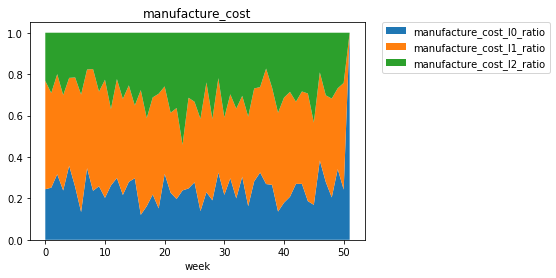

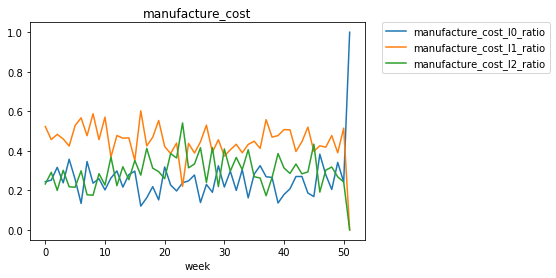

In [10]:
df = agregate(dd, "manufacture_cost")
#df.describe()
plot_year(df, "manufacture_cost")

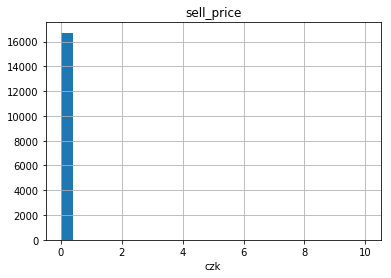

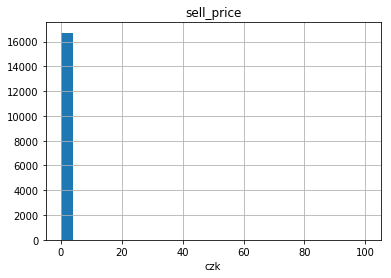

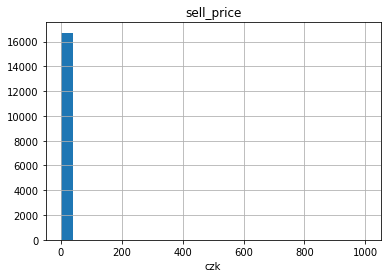

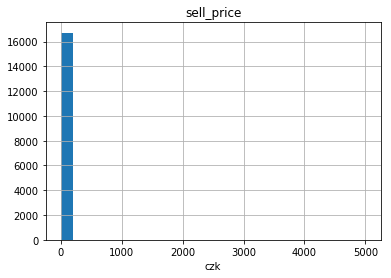

In [11]:
plot_hist(stock_price2, "sell_price", [10, 100,1000,5000], xlabel="czk")

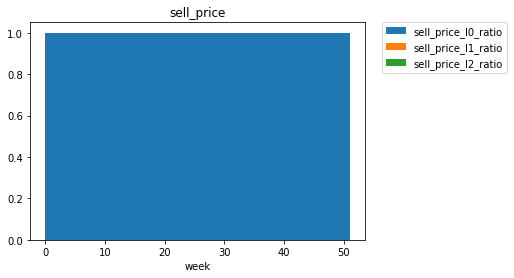

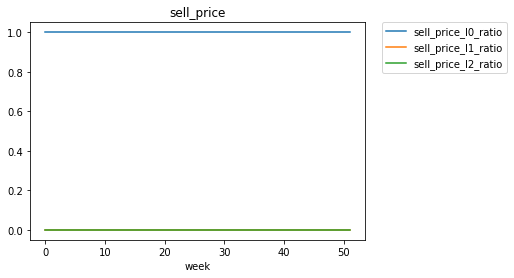

In [12]:
#dataNonEmpty.describe()
df = agregate(dd, "sell_price")
#df.describe()
plot_year(df, "sell_price")

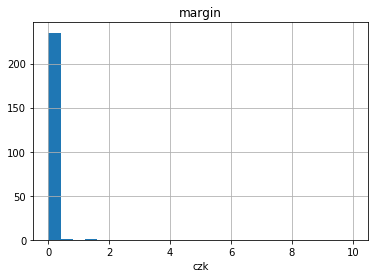

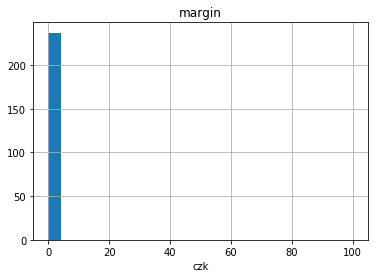

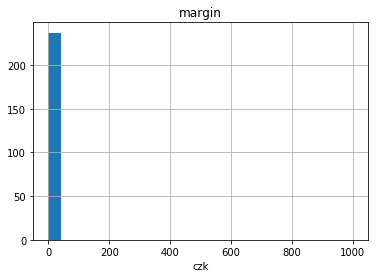

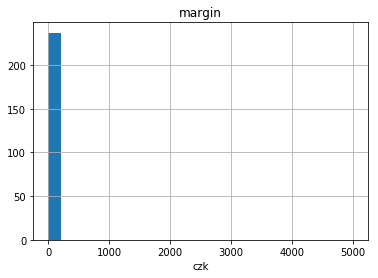

In [13]:
plot_hist(stock_price2, "margin", [10, 100, 1000, 5000], xlabel="czk")

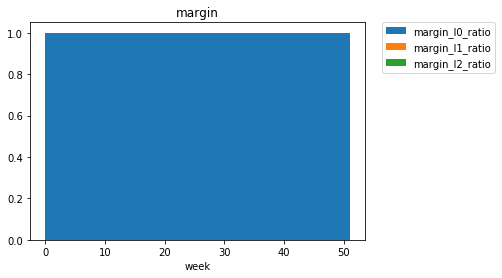

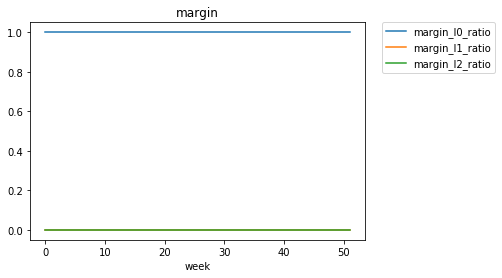

In [14]:
df = agregate(dd, "margin")
plot_year(df, "margin")

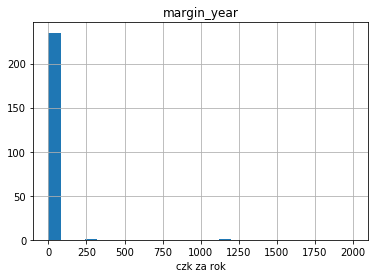

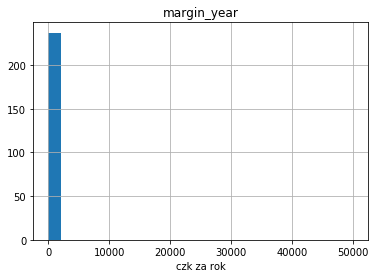

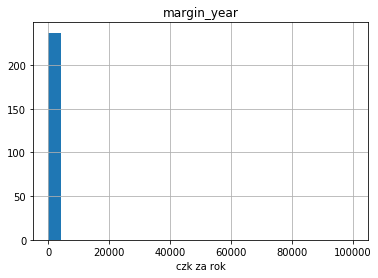

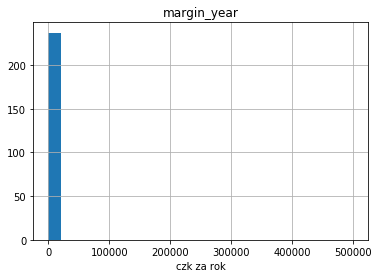

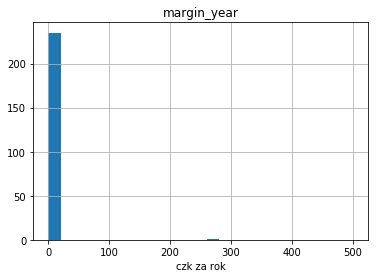

In [15]:
plot_hist(stock_price2, "margin_year", [2000, 50000, 100000, 500000, 500], xlabel="czk za rok")

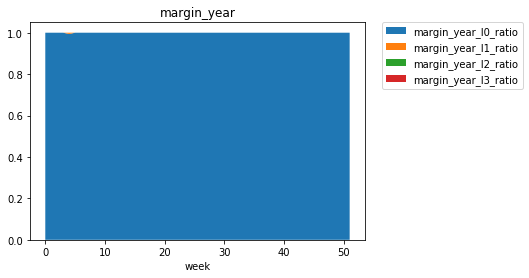

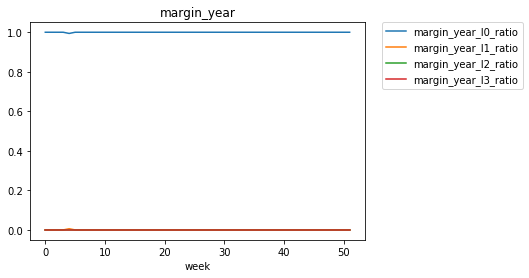

In [16]:
df = agregate(dd, "margin_year")
plot_year(df, "margin_year")

In [17]:
groupedData = dataNonEmpty.group_by("id")
groupedData.mean("dobaZakazka", na="ignore").mean("dobaKus", na="ignore").mean("kusy_odved", na="ignore")
dobaZakazek = groupedData.get_frame()
dobaZakazek.describe()

Rows:3778
Cols:4




id mean_dobaZakazka mean_dobaKus mean_kusy_odved 
 
 
 type enum real real real 
 mins 0.0 0.0 1.0 
 mean 50883.80507715647 3734.9602485130713 121.56952007485557 
 maxs 2322720.0 230400.0 12000.0 
 sigma 66499.19899134018 11018.75880199141 371.461014834307 
 zeros 46 46 0 
 missing 0 0 0 0 
 0 1000121048040 12960.0 64.8 200.0 
 1 1000185628491 29280.0 292.8 100.0 
 2 1000185628691 34200.0 557.9234042553192 74.25 
 3 1000362991001 10080.0 1008.0 25.0 
 4 1000604466040 5209.411764705882 492.04278074866306 12.470588235294118 
 5 1000604496040 23040.0 592.6663502610346 36.06976744186046 
 6 1000604686040 23263.098591549297 320.3278148134677 72.91549295774648 
 7 1000604696040 18671.186440677968 182.7963037741672 99.52542372881356 
 8 1000604706040 12320.0 1994.940170940171 9.666666666666666 
 9 1000604716040 30600.0 1136.2459670764017 25.571428571428573

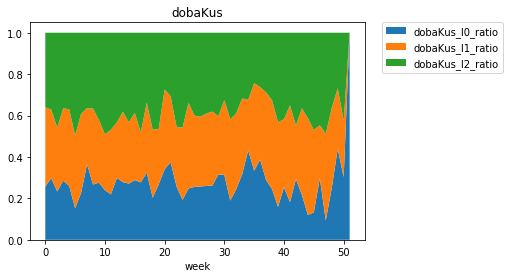

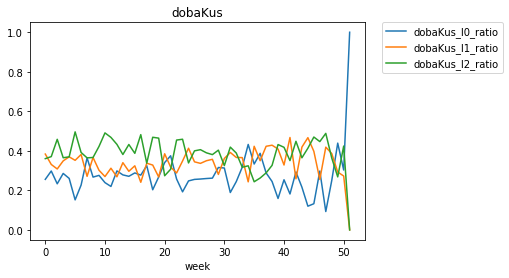

In [18]:
split_to_level(dataNonEmpty, "dobaKus", [180,800])
df = agregate(dataNonEmpty, "dobaKus")
#df.describe()
plot_year(df, "dobaKus")

In [19]:
# opravit
# pro nejkratsi zakazky nula, pro strednedobe 1, pro nejdelsi 2
# vytváří příznakový vektor, pro dobu zakázek
#dobaZakazek["timing"] = dobaZakazek["mean_dobaKus"] > timeComplexity[1]
#dobaZakazek["timing"] += dobaZakazek["mean_dobaKus"] > timeComplexity[0]

In [20]:
# skladová cenak výrobnímu příkazu
# prodejní cena v ceníku - poslední prodejní cena - zatím ne
# náročnos na operace - technická příprava výroby - Výrobní dílce - Alt + Z - technologický postup - TAC
    # počet operací
    # celková doba
    # doba leštění (ano/ne, případně doba)
# oběh zboží a - zboží a služby - sortiment => určování typů výrobků
# pro každý výrobek najít parametry, použit na sortimentu
# kebula

name_complexity = company +"slozitost.csv"

print("Import and Parse data")
complexity = h2o.import_file(path=name_complexity, col_types=["string"] * 2 + ["numeric"] + ["string"])

complexity["operation_name"] = complexity["nazev"]
complexity["product_name"] = complexity["nazev1"].asfactor()
#complexity.describe()
complexity["id"] = complexity["id"].asfactor()
complexity = complexity.drop("nazev1")
complexity = complexity.drop("nazev")

#complexity["polish"] = complexity["operation_name"] == "Bürsten und polieren Handschleiferei"

complexity.describe()

Import and Parse data
Parse progress: |█████████████████████████████████████████████████████████| 100%
Rows:97616
Cols:4




TAC id operation_name product_name 
 
 
 type real enum string enum 
 mins 0.0 NaN 
 mean 189.18975951278492 NaN 
 maxs 300000.0 NaN 
 sigma 1262.0013099381235 NaN 
 zeros 26416 0 
 missing 0 0 0 0 
 0 39.0 1500602926040 SORTIEREN Universalteller 10cm 
 1 31.8 1500602926040 VA 042/232 Universalteller 10cm 
 2 0.0 1500602926040 POSLAT DO GEISLINGENU Universalteller 10cm 
 3 0.0 1500602926040 PĹ™ipravit a vydat dĂ­ly ze skladu Universalteller 10cm 
 4 92.0 1500602926040 POLIEREN INNEN Universalteller 10cm 
 5 92.0 1500602926040 POLIEREN AUSSEN Universalteller 10cm 
 6 18.0 1500602926040 STEMPELN NR.90 Universalteller 10cm 
 7 4.8 1500602926040 REINIGEN 2,4'/ Universalteller 10cm 
 8 102.0 9990603156040 HA-BĂśRST.INNEN MIT Beilagenschale 
 9 6.0 9990603156040 REINIGEN 2,4'/ Beilagenschale

In [21]:
groupedData = complexity.group_by("id")
groupedData.count(na="ignore").mean("TAC", na="ignore").sum("TAC", na="ignore")

taskComplexity = groupedData.get_frame()
taskComplexity["nrow_TAC"] = taskComplexity["nrow"]
taskComplexity.describe()

Rows:13449
Cols:5




id nrow mean_TAC sum_TAC nrow_TAC 
 
 
 type enum int real real int 
 mins 1.0 0.0 0.0 1.0 
 mean 7.258234812997249 177.23191453174815 1373.183698758272 7.258234812997249 
 maxs 65.0 76875.0 307500.0 65.0 
 sigma 4.760646280830819 875.5457773904697 4439.748929153174 4.760646280830819 
 zeros 0 975 975 0 
 missing 0 0 0 0 0 
 0 1000121048040 3.0 53.333333333333336 160.0 3.0 
 1 1000185628491 6.0 45.0 270.0 6.0 
 2 1000185628691 6.0 40.0 240.0 6.0 
 3 1000362991001 2.0 30.0 60.0 2.0 
 4 1000604466040 5.0 98.76 493.8 5.0 
 5 1000604496040 5.0 98.76 493.8 5.0 
 6 1000604686040 6.0 63.333333333333336 380.0 6.0 
 7 1000604696040 7.0 49.65714285714286 347.6 7.0 
 8 1000604706040 4.0 82.5 330.0 4.0 
 9 1000604706040 NEU 11.0 162.72727272727272 1790.0 11.0

In [22]:
taskParameter = taskComplexity.merge(dobaZakazek, all_x = True, all_y = True)
taskParameter = taskParameter.merge(stock_price, all_x = True, all_y = True)
taskParameter.describe()

Rows:60566
Cols:11




id manufacture_cost sell_price margin nrow mean_TAC sum_TAC nrow_TAC mean_dobaZakazka mean_dobaKus mean_kusy_odved 
 
 
 type enum real int real int real real int real real real 
 mins -101.44 0.0 -188258.46 1.0 0.0 0.0 1.0 0.0 0.0 1.0 
 mean 747.2871950631056 0.0 -747.2871950631056 7.272882763201597 168.80596287423663 1324.5102271471267 7.272882763201597 52847.429473967386 3870.638625229367 112.36359424408775 
 maxs 188258.46 0.0 101.44 65.0 76875.0 307500.0 65.0 2322720.0 230400.0 12000.0 
 sigma 3110.9420766680296 0.0 3110.9420766680296 4.65037387127471 885.183633051352 4311.859636275064 4.65037387127471 71637.60334258011 11439.522078292975 382.33765781735946 
 zeros 6477 60566 6477 0 2963 2963 0 152 152 0 
 missing 0 0 0 0 346 346 346 346 43865 43865 43865 
 0 1000121048040 8.79 0.0 -8.79 3.0 53.333333333333336 160.0 3.0 12960.0 64.8 200.0 
 1 1000121048040 8.75 0.0 -8.75 3.0 53.333333333333336 160.0 3.0 12960.0 64.8 200.0 
 2 1000185628491 38.01 0.0 -38.01 6.0 45.0 270.0 6.0 29280.0 292.8 100.0 
 3 1000185628491 45.13 0.0 -45.13 6.0 45.0 270.0 6.0 29280.0 292.8 100.0 
 4 1000185628491 45.52 0.0 -45.52 6.0 45.0 270.0 6.0 29280.0 292.8 100.0 
 5 1000185628691 33.48 0.0 -33.48 6.0 40.0 240.0 6.0 34200.0 557.9234042553192 74.25 
 6 1000185628691 39.02 0.0 -39.02 6.0 40.0 240.0 6.0 34200.0 557.9234042553192 74.25 
 7 1000185628691 39.26 0.0 -39.26 6.0 40.0 240.0 6.0 34200.0 557.9234042553192 74.25 
 8 1000362991001 198.52 0.0 -198.52 2.0 30.0 60.0 2.0 10080.0 1008.0 25.0 
 9 1000362991001 219.4 0.0 -219.4 2.0 30.0 60.0 2.0 10080.0 1008.0 25.0

In [23]:
print(taskParameter[taskParameter["id"] == "3322921000"])
print(stock_price[stock_price["id"] == 3322921000])
print((stock_price["id"] == "1247070700").sum())
print((stock_price["id"] == "3322921000").sum())
print((taskParameter["id"] == "3322921000").sum())


0.0
0.0
0.0


In [24]:
dataM = dataNonEmpty.merge(taskParameter)
dataM = dataM.merge(df)
#dataM.describe()

In [25]:
groupedData = dataNonEmpty.group_by("product_name")
groupedData.mean("dobaZakazka", na="ignore").mean("dobaKus", na="ignore").mean("kusy_odved", na="ignore")
dobaZakazek = groupedData.get_frame()

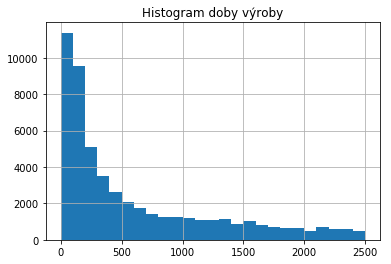

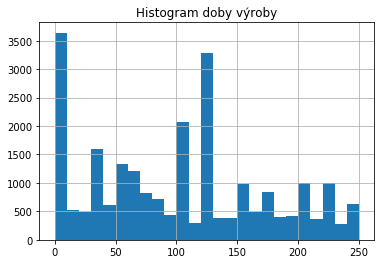

In [26]:
x = taskParameter["sum_TAC"].as_data_frame(use_pandas=True)

x.hist(bins=25, range=[0,2500])
plt.title("Histogram doby výroby")
x.hist(bins=25, range=[0,250])
plt.title("Histogram doby výroby")
plt.show()

['id', 'manufacture_cost', 'sell_price', 'margin', 'nrow', 'mean_TAC', 'sum_TAC', 'nrow_TAC', 'mean_dobaZakazka', 'mean_dobaKus', 'mean_kusy_odved']


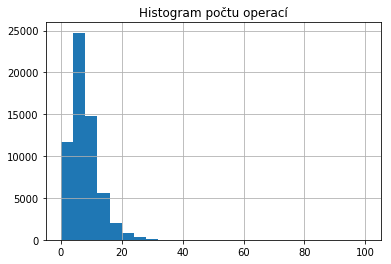

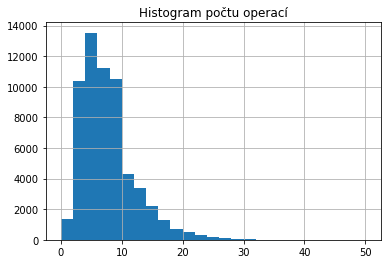

In [27]:
print(taskParameter.columns)
x = taskParameter["nrow_TAC"].as_data_frame(use_pandas=True)

x.hist(bins=25, range=[0,100])
plt.title("Histogram počtu operací")
x.hist(bins=25, range=[0,50])
plt.title("Histogram počtu operací")
plt.show()

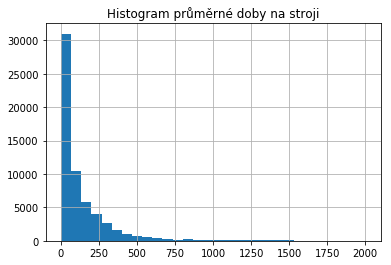

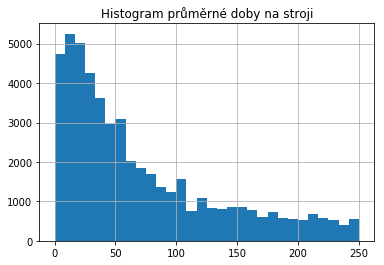

In [28]:
x = taskParameter["mean_TAC"].as_data_frame(use_pandas=True)

x.hist(bins=30, range=[0,2000])
plt.title("Histogram průměrné doby na stroji")
x.hist(bins=30, range=[0,250])
plt.title("Histogram průměrné doby na stroji")
plt.show()

In [29]:
countLimit = [100, 1000]

dataM["countShort"] = dataM["sum_TAC"] < countLimit[0]
dataM["countMiddle"] = dataM["sum_TAC"] > countLimit[0] * dataM["sum_TAC"] < countLimit[1]
dataM["countLong"] = dataM["sum_TAC"] > countLimit[1]

gd =  dataM.group_by(by=["week","year"])
gd.sum("countShort").sum("countMiddle").sum("countLong")
dfM = gd.get_frame()

dfM["sum_all_piece"] = dfM["sum_countShort"] + dfM["sum_countMiddle"] + dfM["sum_countLong"]
dfM["countShortG"] = dfM["sum_countShort"] / dfM["sum_all_piece"]
dfM["countMiddleG"] = dfM["sum_countMiddle"] / dfM["sum_all_piece"]
dfM["countLongG"] = dfM["sum_countLong"] / dfM["sum_all_piece"]

dfM.describe()

Rows:357
Cols:9




week year sum_countShort sum_countMiddle sum_countLong sum_all_piece countShortG countMiddleG countLongG 
 
 
 type int int int int int int real real real 
 mins 1.0 2010.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
 mean 25.66386554621849 2013.1456582633052 9.280112044817928 1.1316526610644257 16.019607843137255 26.431372549019606 0.3093027149996314 0.043090500673061284 0.6476067843273073 
 maxs 52.0 2017.0 183.0 78.0 165.0 348.0 1.0 0.5 1.0 
 sigma 14.727836506481413 2.0693223191219046 19.88011744558699 5.219564622198763 25.857586565490767 41.654395637433105 0.3160696054610914 0.11874012553370329 0.3541172536580369 
 zeros 0 0 152 309 68 33 119 276 35 
 missing 0 0 0 0 0 0 33 33 33 
 0 1.0 2011.0 5.0 0.0 40.0 45.0 0.1111111111111111 0.0 0.8888888888888888 
 1 1.0 2012.0 4.0 0.0 22.0 26.0 0.15384615384615385 0.0 0.8461538461538461 
 2 1.0 2013.0 11.0 11.0 9.0 31.0 0.3548387096774194 0.3548387096774194 0.2903225806451613 
 3 1.0 2014.0 4.0 0.0 0.0 4.0 1.0 0.0 0.0 
 4 1.0 2016.0 12.0 12.0 0.0 24.0 0.5 0.5 0.0 
 5 1.0 2017.0 12.0 0.0 2.0 14.0 0.8571428571428571 0.0 0.14285714285714285 
 6 2.0 2011.0 25.0 0.0 7.0 32.0 0.78125 0.0 0.21875 
 7 2.0 2012.0 5.0 0.0 5.0 10.0 0.5 0.0 0.5 
 8 2.0 2013.0 4.0 0.0 22.0 26.0 0.15384615384615385 0.0 0.8461538461538461 
 9 2.0 2014.0 0.0 0.0 0.0 0.0 nan nan nan

In [30]:
## week 13
########################################################################################################
######################################## stav skladu ###################################################
########################################################################################################
# Vizualizace mnozstvi polotovaru na skladu

In [31]:
# načtení dat popisujích pohyb zakázek na skladu
from matplotlib.dates   import  DateFormatter,    \
                                AutoDateLocator,   \
                                HourLocator,        \
                                MinuteLocator,       \
                                epoch2num
from matplotlib.ticker  import  ScalarFormatter, FuncFormatter


# print("Import and Parse data")
# stock_move = h2o.import_file(path=name, col_types=2*["string"] + ["numeric"] * 4 + ["time"] + ["numeric"] * 4)
# stock_move["id"] = stock_move["id"].asfactor()

# # stock_move.describe()
# # print(stock_move)

task_parameter_pd = taskParameter.as_data_frame(use_pandas=True)
task_parameter_pd.reset_index().to_csv(company + "task_parameter_pd.csv", encoding = "utf8", sep=";")

# print(task_parameter_pd.shape)
# # names = stock_move[["id"] + ["product_name"]].as_data_frame(use_pandas=True)

# print(stock_move.columns)

In [32]:
task_parameter_pd.reset_index().columns

Index(['index', 'id', 'manufacture_cost', 'sell_price', 'margin', 'nrow',
       'mean_TAC', 'sum_TAC', 'nrow_TAC', 'mean_dobaZakazka', 'mean_dobaKus',
       'mean_kusy_odved'],
      dtype='object')

In [33]:
# get days of manufacture command
mc = pd.read_csv(COMPANY_FOLDER + "/manufacture_command.csv", sep=',')
manufacture_command_days = list(sorted(set(list(mc.start_date.dropna().astype("int").unique()) + list(mc.end_date.dropna().astype("int").unique()))))
#days

In [34]:
company

'pribory/'

In [35]:
print(pd.__version__)
name = company +"stock_load.csv"
pd_stock_move = pd.read_csv(name, sep=',')
pd_stock_move["id"] = pd_stock_move["id"].astype("str")
pd_stock_move = pd_stock_move[pd_stock_move["date"].notnull()]

pd_stock_move["date"] = pd_stock_move["date"].astype("uint64")
print(pd_stock_move.shape)
pd_stock_move["sign_amount"] = pd_stock_move["sign_amount"].astype("int")



pd_stock_move_plus = pd_stock_move.ix[pd_stock_move["sign_amount"] >= 0]
pd_stock_move_minus= pd_stock_move.ix[pd_stock_move["sign_amount"] < 0]

days = list(sorted(set(list(pd_stock_move["date"].dropna().unique()) + manufacture_command_days)))
np.savetxt(company + "days.txt", days,  fmt='%d')


products = pd_stock_move.groupby("id").agg({"sign_amount" : np.sum})

products_plus= pd_stock_move_plus.groupby(["id"]).agg({"sign_amount" : np.sum})

products_minus= pd_stock_move_minus.groupby(["id"]).agg({"sign_amount" : np.sum})



# print(products_minus)
print(pd_stock_move_plus.columns)
print(pd_stock_move_plus.shape)
print(pd_stock_move_minus.shape)

0.20.3
(137401, 11)


c:\programdata\miniconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  del sys.path[0]


Index(['id', 'product_name', 'store_group', 'load_unload', 'amount',
       'sign_amount', 'date', 'year', 'month', 'day', 'order_id'],
      dtype='object')
(58763, 11)
(78638, 11)


In [36]:
## Výpis nejpouživanějších, nejméně používaných prototypů a prototypů mezi min_value a max_value

#var min_value
min_value = 1000
#var max_value
max_value = 6000

a = products_plus["sign_amount"] > min_value
b = products_plus["sign_amount"] < max_value

# printpd_stock_move(list(products_plus[a & b].as_matrix()[:,0]))
print(products_plus.sort_values(["sign_amount"], ascending=[False]).index.values[0:10])
print(products_minus.sort_values(["sign_amount"], ascending=[True]).as_matrix()[:,0])

['1000625006040' '2053322595000' '1050660556035' '1050609559990'
 '1050660079990' '2053322932000' '2000663266035' '1050660566035'
 '2003632866000' '1050660559990']
[-171636  -85899  -79700 ...,      -1      -1      -1]


In [37]:
## Přetransformování naskladňovacích operací do matice ve tvaru prototyp x datum
### Datumy jsou z rozsahu jak pro vyskladňování, tak pro naskladňování
### Index je sloupeček 0 (kvůli padnas)
import math

# print(pd_stock_move_plus[["date", "id"]].shape)
# print(pd_stock_move_plus["date"])
# print(pd_stock_move_plus[["sign_amount"]].shape)

result_plus = pd_stock_move_plus.groupby(["date", "id"]).agg({"sign_amount" : np.sum})

cols = [0] + list(days)

data_plus = pd.DataFrame(index=products.index.values,columns=cols, dtype='int')
print(data_plus.columns)

nans = 0

i = 0

for index, it in result_plus.iterrows(): 
    
    dat = index[0]
    id = index[1]

    
    if not i % 1000:
        print(i, "of", result_plus.shape[0])

    
    i = i + 1
    
    if not math.isnan(dat):
        data_plus.xs(id)[dat] = it["sign_amount"]
        data_plus.xs(id)[0] = id
#         name = stock_move[stock_move["id"] == "6821651000"]["product_name"].as_data_frame(use_pandas=True).get_value(0,0,takeable=True)
#         data_plus.xs(it["id"])[0] = name
    else:
        nans = nans + 1
        
sh = data_plus.shape

miss = (sh[0] - 1) * sh[1] -  data_plus.isnull().sum().sum() - result_plus.shape[0]
        
print("Nans:", data_plus.isnull().sum().sum(), "of:", sh[0] * sh[1], "missing:", miss)

data_plus = data_plus.fillna(0)
print(data_plus.shape)

Int64Index([         0, 1263942000, 1264028400, 1264114800, 1264374000,
            1264460400, 1264546800, 1264633200, 1264719600, 1264806000,
            ...
            1488841200, 1488927600, 1489014000, 1489100400, 1489186800,
            1489359600, 1489446000, 1489532400, 1489618800, 1489705200],
           dtype='int64', length=1886)
0 of 49683
1000 of 49683
2000 of 49683
3000 of 49683
4000 of 49683
5000 of 49683
6000 of 49683
7000 of 49683
8000 of 49683
9000 of 49683
10000 of 49683
11000 of 49683
12000 of 49683
13000 of 49683
14000 of 49683
15000 of 49683
16000 of 49683
17000 of 49683
18000 of 49683
19000 of 49683
20000 of 49683
21000 of 49683
22000 of 49683
23000 of 49683
24000 of 49683
25000 of 49683
26000 of 49683
27000 of 49683
28000 of 49683
29000 of 49683
30000 of 49683
31000 of 49683
32000 of 49683
33000 of 49683
34000 of 49683
35000 of 49683
36000 of 49683
37000 of 49683
38000 of 49683
39000 of 49683
40000 of 49683
41000 of 49683
42000 of 49683
43000 of 49683
44000 of 

In [38]:
data_plus.shape

(4221, 1886)

In [39]:
if False:
    data_plus_en = data_plus.merge(task_parameter_pd, left_on=0, right_on="id", how='left')
    data_plus_en = data_plus_en.drop_duplicates(subset=[0]).set_index(0)

    data_plus_en = data_plus_en.merge(pd_stock_move[["id","product_name"]].drop_duplicates("id"), how="left", left_index=True, right_on="id")
    # print(data_plus_en)
    data_plus_en = data_plus_en.reset_index().drop_duplicates(subset="id").set_index("id")

    data_plus.to_csv(company + "data_plus.csv")
    print("import completed, not imported items:", nans)
    print(data_plus.shape)
    print(data_plus_en.shape)
# it = data_plus.get_value(0,0,takeable=True)
# print(it)

# print(task_parameter_pd)
# print(task_parameter_pd.loc[task_parameter_pd.id == str(it)])
# print(task_parameter_pd.shape)
# print(task_parameter_pd["id" == it])

# print(task_parameter_pd.ix[])

In [40]:
## Přetransformování vyskladňovacích operací do matice ve tvaru prototypy x datum
### Datumy jsou z rozsahu jak pro vyskladňování, tak pro naskladňování

result_minus = pd_stock_move_minus.groupby(["date", "id"]).agg({"sign_amount" : np.sum})

cols = [0] + list(days)

data_minus = pd.DataFrame(index=products.index.values,columns=cols, dtype='int')
print(data_minus.columns)

nans = 0

i = 0

for index, it in result_minus.iterrows(): 
    
    dat = index[0]
    id = index[1]

    
    if not i % 1000:
        print(i, "of", result_minus.shape[0])

    
    i = i + 1
    
    if not math.isnan(dat):
        data_minus.xs(id)[dat] = it["sign_amount"]
        data_minus.xs(id)[0] = id
#         name = stock_move[stock_move["id"] == "6821651000"]["product_name"].as_data_frame(use_pandas=True).get_value(0,0,takeable=True)
#         data_plus.xs(it["id"])[0] = name
    else:
        nans = nans + 1
        
sh = data_plus.shape

miss = (sh[0] - 1) * sh[1] -  data_minus.isnull().sum().sum() - result_minus.shape[0]
        
print("Nans:", data_minus.isnull().sum().sum(), "of:", sh[0] * sh[1], "missing:", miss)

data_minus = data_minus.fillna(0)
print(data_minus.shape)

Int64Index([         0, 1263942000, 1264028400, 1264114800, 1264374000,
            1264460400, 1264546800, 1264633200, 1264719600, 1264806000,
            ...
            1488841200, 1488927600, 1489014000, 1489100400, 1489186800,
            1489359600, 1489446000, 1489532400, 1489618800, 1489705200],
           dtype='int64', length=1886)
0 of 64486
1000 of 64486
2000 of 64486
3000 of 64486
4000 of 64486
5000 of 64486
6000 of 64486
7000 of 64486
8000 of 64486
9000 of 64486
10000 of 64486
11000 of 64486
12000 of 64486
13000 of 64486
14000 of 64486
15000 of 64486
16000 of 64486
17000 of 64486
18000 of 64486
19000 of 64486
20000 of 64486
21000 of 64486
22000 of 64486
23000 of 64486
24000 of 64486
25000 of 64486
26000 of 64486
27000 of 64486
28000 of 64486
29000 of 64486
30000 of 64486
31000 of 64486
32000 of 64486
33000 of 64486
34000 of 64486
35000 of 64486
36000 of 64486
37000 of 64486
38000 of 64486
39000 of 64486
40000 of 64486
41000 of 64486
42000 of 64486
43000 of 64486
44000 of 

In [41]:
if False:
    data_minus_en = data_minus.merge(task_parameter_pd, left_on=0, right_on="id", how='left')
    data_minus_en = data_minus_en.drop_duplicates(subset=[0]).set_index(0)
    data_minus_en = data_minus_en.merge(pd_stock_move[["id","product_name"]].drop_duplicates("id"), how="left", left_index=True, right_on="id")
    data_minus_en = data_minus_en.reset_index().drop_duplicates(subset="id").set_index("id")
    data_minus.to_csv(company + "data_minus.csv")

    print("import completed, not imported items:", nans)
    print(data_minus.shape)
    print(data_minus_en.shape)
#print(data_minus_en.columns)


In [42]:
## Vygenerování průběžného stavu skladu
sorted_days = sorted(days)
cols = [0] + list(sorted_days)

prev = ""

# print(days.get_value(1, "date"))

data_cont = pd.DataFrame(0, index=products.index.values,columns=cols, dtype='int')
data_cont.ix[:,0] = data_plus.ix[:,0]

# print(data_cont.ix[:,1])
# print(days)
# print(cols)


for index, it in np.ndenumerate(sorted_days):
    index = index[0]
#     
    if index != 0:
#         print("index:", index, "item",it)
        data_cont.ix[:, it] = data_cont.ix[:,prev]
    if not index % 50:
        print(index, "of", len(days))
        
    data_cont.ix[:,it] = data_cont.ix[:,it] + data_plus.ix[:, it] + data_minus.ix[:,it]
    prev = it
    
# print(data_cont)
    
data_cont = data_cont.fillna(0)




c:\programdata\miniconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.


0 of 1885


c:\programdata\miniconda3\lib\site-packages\ipykernel_launcher.py:26: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


50 of 1885
100 of 1885
150 of 1885
200 of 1885
250 of 1885
300 of 1885
350 of 1885
400 of 1885
450 of 1885
500 of 1885
550 of 1885
600 of 1885
650 of 1885
700 of 1885
750 of 1885
800 of 1885
850 of 1885
900 of 1885
950 of 1885
1000 of 1885
1050 of 1885
1100 of 1885
1150 of 1885
1200 of 1885
1250 of 1885
1300 of 1885
1350 of 1885
1400 of 1885
1450 of 1885
1500 of 1885
1550 of 1885
1600 of 1885
1650 of 1885
1700 of 1885
1750 of 1885
1800 of 1885
1850 of 1885


In [43]:
data_cont.to_csv(company + "data_cont.csv", encoding = "utf8", sep=";")
data_cont.columns
data_cont.shape
#data_cont[0]

(4221, 1886)

In [44]:
data_cont.iloc[:, 0]
# task_parameter_pd


1000121048040                                          1000121048040
1000185628491                                          1000185628491
1000185628691                                          1000185628691
1000362991001                                          1000362991001
1000604466040                                          1000604466040
1000604496040                                          1000604496040
1000604686040                                          1000604686040
1000604696040                                          1000604696040
1000604706040                                          1000604706040
1000604716040                                          1000604716040
1000610826044                                          1000610826044
1000610856041                                          1000610856041
1000610856044                                          1000610856044
1000610876042                                          1000610876042
1000610876043                     

In [45]:
task_parameter_pd[task_parameter_pd.id == "1"]

Empty DataFrame
Columns: [id, manufacture_cost, sell_price, margin, nrow, mean_TAC, sum_TAC, nrow_TAC, mean_dobaZakazka, mean_dobaKus, mean_kusy_odved]
Index: []

In [46]:
task_parameter_pd.id[0]
data_cont[0][0]
#data_cont_en.

'1000121048040'

In [47]:
data_cont_en = data_cont.merge(task_parameter_pd, left_on=0, right_on="id", how='left')
data_cont_en = data_cont_en.drop_duplicates(subset=[0]).set_index(0)
data_cont_en = data_cont_en.merge(pd_stock_move[["id","product_name"]].drop_duplicates("id"), how="left", left_index=True, right_on="id")
data_cont_en = data_cont_en.reset_index().drop_duplicates(subset="id").set_index("id")
print(data_cont.shape)
print(data_cont_en.shape)
print(sum(data_plus_en.manufacture_cost.isnull()))
print(sum(pd_stock_move.product_name.isnull()))
data_cont_en.shape

(4221, 1886)
(4221, 1899)


NameError: name 'data_plus_en' is not defined

In [ ]:
"id_x" in data_cont_en.columns
data_cont_en.reset_index().loc[0].id

#data_cont_en[(data_cont_en["id"] != data_cont_en["id_x"])]


In [ ]:
delta = np.diff(days) / 86400

integrated_pieces = (data_cont[days[:-1]] * delta).sum(axis=1)
integrated_cost = integrated_pieces*data_cont_en["manufacture_cost"]

data_cont_en["integrated_pieces"] = integrated_pieces
data_cont_en["integrated_cost"] = integrated_cost
data_cont_en.shape

In [ ]:
#data_cont_en.sort_values(["integrated_pieces"], ascending=[0])["integrated_pieces"].reset_index()["id"].values[0:1000]

In [ ]:
#Zjištění počtu zakázek pro polotovar

pd_stock_move = pd_stock_move.reset_index()
semi_order = pd_stock_move[["id", "order_id"]].drop_duplicates().groupby(["id"]).count()
semi_order = semi_order.rename(columns={"order_id": "count_of_order"})

data_cont_en = data_cont_en.merge(semi_order, how="left", left_index=True, right_index=True)
print(semi_order.sort_values("count_of_order"))

pd_stock_move = pd_stock_move.set_index("id")
data_cont_en.shape

In [ ]:
#Zjištění "integrálů" finančního stavu pro polotovar

In [ ]:
# nalezeni priznaku 

task_data_pd = dataNonEmpty.as_data_frame(use_pandas=True)
task_data_pd["CisloZakazky"] = task_data_pd["CisloZakazky"].fillna(-1).astype(int)
task_data_pd_cislo_zakazky = task_data_pd.set_index("CisloZakazky")
# task_data_pd = task_data_pd.set_index("id")
print(task_data_pd.columns)
print(data_cont_en.columns)
data_cont_en.shape

In [ ]:
name = company + "zakazky.csv"
pd_task_data = pd.read_csv(name, sep=';')
pd_task_data_cislo_zakazky = pd_task_data.set_index("CisloZakazky")
#print(pd_task_data_cislo_zakazky)

In [ ]:
# polotovary s nejvyšší cenou
#data_cont_en.sort_values("manufacture_cost")[["manufacture_cost"]]

In [ ]:
plt.plot(data_cont_en.sell_price, data_cont_en.nrow_TAC, 'r.')
plt.xlabel("prodejní cena")
plt.ylabel("počet strojních operací")
plt.show()


In [ ]:
import math

def add_series_to_graph(df, it, dates, dates_label, ax, price, label):
    if not df.loc[it].empty:
        row = df.loc[it, dates]
        if price:
            price_val = df.loc[it]["manufacture_cost"]
        else:
            price_val = 1
            
        if math.isnan(price_val):
            print("Produkt", it, "nemá cenu.")
#         print(row[cols_selector_l].as_matrix().transpose())
#         print(row.as_matrix().transpose() * price_val)
#         print(len(dates_label))
#         print(row.shape)
        ax.bar(dates_label, row.as_matrix().transpose() * price_val, label=label)
    else:
        print("řada neexistuje")

def plot_stock_bar(ids = ["3631866810", "3320293000", "3323599000", "3323323000"], name = "", from_time=1417305600, to_time=1448841600, df=None, price=False, legend=True):
    if price:
        y_label = "finanční stav"
    else:
        y_label = "pocet kusu"
    dates = days
    dates = dates[(dates > from_time) & (dates < to_time)]

    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)
    ax.set_title(name,fontsize= 30)

    dates_label = [dt.datetime.fromtimestamp(ts) for ts in dates]

    plt.subplots_adjust(bottom=0.2)
    plt.xticks(rotation=40, size=14)
    
    it = ids[0]
    for it in ids:
        label = str(it) + "\n" + str(df.loc[it,"product_name"])
#         print(label)
        add_series_to_graph(df, it, dates, dates_label, ax, price, label)
    if legend:
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size':15})
    plt.xlabel('čas', fontsize=20)
    plt.ylabel(y_label, fontsize=20)

    xfmt = md.DateFormatter('%Y-%m-%d')
#     ax.xaxis.set_major_formatter(xfmt)

    plt.show()

def plot_stock(ids = ["3631866810","3320293000", "3323599000", "3323323000"], name = "", from_time=1417305600, to_time=1448841600, price=False, legend=True, minus_graph=True, plus_graph=True, plus_minus_graph=True, flow_graph=True ):
    if price:
        y_label = "finanční stav"
    else:
        y_label = "pocet kusu"

    if plus_graph:
        plot_stock_bar(ids, name + " - naskladneni", from_time, to_time, data_plus_en, price, legend)
    if minus_graph:
        plot_stock_bar(ids, name + " - vyskladneni", from_time, to_time, data_minus_en, price, legend)
    
#     dates = days / 1000
    dates = days
#     cols_selector = list()
    dates = dates[(dates > from_time) & (dates < to_time)]
    
    dates_label = [dt.datetime.fromtimestamp(ts) for ts in dates]
  
    if plus_minus_graph:
        fig = plt.figure(figsize=(20,10))
        ax = fig.add_subplot(111)
        ax.set_title(name + " - naskladneni(+) a vyskladneni(-)",fontsize= 30)
        xfmt = md.DateFormatter('%Y-%m-%d')

        plt.subplots_adjust(bottom=0.2)
        plt.xticks(rotation=40, size=14)

        for it in ids:
            label = str(it) + "\n" + str(data_plus_en.loc[it,"product_name"])

            add_series_to_graph(data_plus_en, it, dates, dates_label, ax, price,  label + " - naskl")
            add_series_to_graph(data_minus_en, it, dates, dates_label, ax, price, label + " - vyskl")

    #     ax.xaxis.set_major_formatter(xfmt)

        if legend:
            plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size':15})
        plt.xlabel('čas', fontsize=20)
        plt.ylabel(y_label, fontsize=20)

        plt.show()
    
    if flow_graph:
        fig = plt.figure(figsize=(20,10))
        ax = fig.add_subplot(111)
        ax.set_title(name + " - prubezny stav skladu",fontsize= 30)
        xfmt = md.DateFormatter('%Y-%m-%d')

        plt.subplots_adjust(bottom=0.2)
        plt.xticks(rotation=40, size=14)

    #     cols_selector_l = [False] + cols_selector + 10 * [False]
        for it in ids:
    #         add_series_to_graph(data_plus_en, it, dates, dates_label, ax, price,  str(it) + " - naskl")
    #         add_series_to_graph(data_minus_en, it, dates, dates_label, ax, price, str(it) + " - vyskl")
            if not data_cont_en.loc[it].empty:
                idx = data_cont_en.loc[it].index.tolist()
    #             print(idx)
                if idx:
                    idx = idx[0]
                else:
                    print("no data found", it)
                    break

                row = data_cont_en.loc[it, dates]
                if price:
                    price_val = data_cont_en.loc[it]["manufacture_cost"]
                else:
                    price_val = 1
                if math.isnan(price_val):
                    print("Produkt", it, "nemá cenu.")
                else:
                    label = str(it) + "\n"+ str(data_cont_en.loc[it,"product_name"])
                    lin = ax.plot(dates_label, row.as_matrix().transpose() * price_val, label=label)[0]

                    lin_col = lin.get_color()

                    tasks = pd_stock_move.loc[it,"order_id"]
                    if isinstance(tasks, pd.core.series.Series):
                        tasks = tasks.unique()
                        tasks = tasks[pd.notnull(tasks)]
                        
                        if pd_task_data_cislo_zakazky.index.isin(tasks).any():   
                            order_point = (pd_task_data_cislo_zakazky.loc[tasks].dropna()["zadani_X"].as_matrix().transpose()).astype(int)
                            order_point = order_point[(order_point > from_time) & (order_point < to_time)]
                            order_point_dates = [dt.datetime.fromtimestamp(ts) for ts in order_point]
                            order_point_values = row[order_point]

                            ax.plot(order_point_dates, order_point_values * price_val, "o", color = lin_col, label="zadani", markersize=10)

                            order_point = (pd_task_data_cislo_zakazky.loc[tasks].dropna()["ukonceni_X"].as_matrix().transpose()).astype(int)
                            order_point = order_point[(order_point > from_time) & (order_point < to_time)]
                            order_point_dates = [dt.datetime.fromtimestamp(ts) for ts in order_point]
                            order_point_values = row[order_point]

                            ax.plot(order_point_dates, order_point_values * price_val, "X", color = lin_col, label="ukonceni", markersize=10)




            else:
                print("řada neexistuje")

    #     ax.xaxis.set_major_formatter(xfmt)
        if legend:
            plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size':15})
        plt.xlabel('čas', fontsize=20)
        plt.ylabel(y_label, fontsize = 20)

        plt.show()

In [ ]:
l = ['3632866000', '0663266035', '3620806006', '3632866043', '6833300270']
#plot_stock(l, name="Polotovary s největším množstvím vyrobených kusů")
#plot_stock(l, name="Polotovary s největším množstvím vyrobených kusů", price=True)

In [ ]:
#1417305600
#2014 - 1388534400
#2015 - 1420070400
#2016 - 1451606400

# print(data_cont_en.columns)

from prepare_data import create_grouped_column


create_grouped_column(data_cont_en, days, 1388534400, 1420070400, "2014")
create_grouped_column(data_cont_en, days, 1420070400, 1451606400, "2015")

data_cont_en.shape

In [ ]:
from utils import *

In [ ]:
l2 =  ["manufacture_cost", "nrow_TAC"]
multi_scatter(data_cont_en, l2, "manufacture_cost")

In [ ]:
l =  ["mean_stock_load_2014", "median_stock_load_2014", "var_stock_load_2014", "mean_stock_cost_2014", "var_stock_cost_2014",
      "mean_stock_load_2015", "median_stock_load_2015", "var_stock_load_2015", "mean_stock_cost_2015", "var_stock_cost_2015",
      "sell_price", "manufacture_cost", "margin", "nrow_TAC", "sum_TAC", "count_of_order", "integrated_pieces", 
      "integrated_cost"]
#multi_scatter(data_cont_en, l, "manufacture_cost")

In [ ]:
print([x for x in data_cont_en.columns if x not in days])

In [ ]:
l2 =  ["manufacture_cost", "median_stock_load_2015", "nrow_TAC", "sum_TAC", "count_of_order", "integrated_cost"]
#multi_scatter(data_cont_en, l2, "manufacture_cost")

In [ ]:
cols = [x for x in data_cont_en.columns if x not in days]
data_cont_en[(data_cont_en["integrated_cost"] < 0)].loc[:,cols].to_csv(company + "negative_integrated_cost.csv")
#data_cont_en[(data_cont_en["integrated_cost"] < 0)].to_csv("negative_integrated_cost.csv")

In [ ]:
#data_cont_en.to_csv("data/data_cont_en.csv", encoding = "utf8")
data_plus_en.to_csv(company +"data_plus_en.csv", encoding = "utf8")
data_minus_en.to_csv(company + "data_minus_en.csv", encoding = "utf8")
# pd_stock_move.to_csv(company +"pd_stock_move.csv", encoding = "utf8")
# pd_task_data_cislo_zakazky.to_csv(company + "pd_task_data_oreder_id.csv", encoding = "utf8")

In [ ]:

days

In [ ]:
# Calculate task ending in next n days


In [ ]:
name = company +"material.csv"
material = pd.read_csv(name, sep=';')

print(material.shape)

material_m = material.groupby(["id"])["amount"].agg(["sum", "mean", "count"])
material_m = material_m.reset_index()
material_m = material_m.rename(columns={"sum":"material_sum", "mean":"material_mean", "count": "material_nrow"})

#groupedData = material.group_by("id")
#groupedData.count(na="ignore").mean("amount", na="ignore").sum("amount", na="ignore")

#taskComplexity = groupedData.get_frame()
#taskComplexity.describe()
#material

In [ ]:
data_cont_en = data_cont_en.reset_index()
data_cont_en_e = pd.merge(data_cont_en, material_m, left_on="id", right_on="id", how="left")
"material_mean" in data_cont_en.columns, "material_nrow" in data_cont_en.columns
data_cont_en_e.columns[-5:]
#data_cont_en_e[["material_sum", "material_mean", "material_nrow"]] = data_cont_en_e[["material_sum", "material_mean", "material_nrow"]].fillna(0)
data_cont_en_e.shape

In [ ]:
data_cont_en.reset_index().to_csv(company + "data_cont_en.csv", encoding = "utf8", sep=";")
# pd_task_data.reset_index().to_csv(company + "pd_task_data.csv", encoding = "utf8", sep=";")

In [ ]:
# data_cont_en.reset_index().columns[1886]
# name = "data/manufacture_command.csv"
# manufacture_command = pd.read_csv(name, sep=';')
# manufacture_command.columns

In [ ]:
data_cont_en.shape

In [ ]:
# if "id" not in data_cont_en_e.columns:
#     data_cont_en_e = data_cont_en_e.reset_index()

# manufacture_command = manufacture_command[manufacture_command["start_date"].notnull()]
# manufacture_command = manufacture_command[manufacture_command["end_date"].notnull()]
# manufacture_command["start_date"] = manufacture_command["start_date"].astype("int")
# manufacture_command["end_date"] = manufacture_command["end_date"].astype("int")
# manufacture_command.shape
    
# manufacture_command.merge(data_cont_en_e, left_on="product_id", right_on="id").shape
# #manufacture_command.shape

In [ ]:
# from prepare_data import calculate_manufacture_command
# from config import COMPANY_FOLDER, WEIGHT_DICT, NAME_MAP, LENGTH_ARR

# cache = dict()

# name = "data/manufacture_command.csv"
# max_len_arr = max(LENGTH_ARR) + 1


# manufacture_command = pd.read_csv(name, sep=';')
# aa = calculate_manufacture_command(data_cont_en_e, pd_task_data, manufacture_command, material, days, WEIGHT_DICT, NAME_MAP, lambda x: False)

In [ ]:
# manufacture_command.loc[64]

In [ ]:
# # Vypocet priznaku pro vyrobni priznaky dle navrhupredikce
# import datetime
# import itertools

# from prepare_data import calculate_manufacture_command_item
# from config import COMPANY_FOLDER, WEIGHT_DICT, NAME_MAP, LENGTH_ARR


# name = "data/manufacture_command.csv"
# manufacture_command = pd.read_csv(name, sep=';')
# manufacture_command = manufacture_command[manufacture_command["start_date"].notnull()]
# manufacture_command = manufacture_command[manufacture_command["end_date"].notnull()]
# manufacture_command["start_date"] = manufacture_command["start_date"].astype("int")
# manufacture_command["end_date"] = manufacture_command["end_date"].astype("int")
# manufacture_command.shape

# manufacture_command = manufacture_command[0:1000]

# # manfacture_command = manfacture_command.reset_index()
# price = 20000
# len_day = 121
# idx = 0
# idd = 0

# # row = itertools.islice(manufacture_command.iterrows(), 800)
# row = manufacture_command.iterrows()

# if "id" not in data_cont_en.columns:
# data_cont_en = data_cont_en.reset_index()

# not_in = 0

# cache = dict()

# base = 0
# indicies = list(range(base,base+1000))

# max_len_arr = max(LENGTH_ARR) + 1

# for index, it in row: 
# if not index % 1000:
# print(index, "of", manufacture_command.shape[0], ",", not_in, "not included.")
# if index in indicies:
# a = calculate_manufacture_command_item(index, data_cont_en, pd_task_data, manufacture_command,material, days, WEIGHT_DICT, NAME_MAP, max_len_arr, cache)

# not_in = not_in + a
# if a:
# print(not_in, index, it.idd)


# print("not in data cont en:", not_in)

# data_cont_en = data_cont_en.set_index("id")

In [ ]:
#calculate_manufacture_command_item(613, data_cont_en.reset_index(), pd_task_data, manufacture_command,material, days, WEIGHT_DICT, NAME_MAP, max_len_arr, cache)


In [ ]:
# manufacture_command.iloc[613]

In [ ]:
#data_cont_en['0620036041']
(data_cont_en.reset_index().id == '0620036041').sum()

In [ ]:
#name = "data/manufacture_command_ex.csv"
#manufacture_command = pd.read_csv(name, sep=';')
#manufacture_command.columns, manufacture_command.shape

In [ ]:
# manufacture_command = aa

In [ ]:
# if "Unnamed: 0" in manufacture_command.columns:
#     manufacture_command = manufacture_command.drop(["Unnamed: 0"], axis=1)

# manufacture_command.shape

In [ ]:
# nalezení počátečního mesíce a end_stock_price
#manufacture_command["end_stock_price"] = manufacture_command["actual_cost"]  + manufacture_command["command_price"]
#manufacture_command["start_month"] = pd.to_datetime(manufacture_command['start_date'], unit='s').dt.month

In [ ]:
#manufacture_command = pandas.merge(manufacture_command, data_cont_en[["id","nrow_TAC","sum_TAC", "mean_TAC", "material_nrow", "material_sum", "material_mean"]], left_on="product_id", right_on="id")

In [ ]:
name = company + "manufacture_command_ex.csv"
manufacture_command = pd.read_csv(name)
manufacture_command.columns

In [ ]:
#nalezení výrobních příkazů pro polotovary
manufacture_command_semi = manufacture_command[manufacture_command["ongoing_task"].notnull()]
manufacture_command_semi.shape

In [ ]:
#plt.boxplot()
#plt.show()
(np.isnan(manufacture_command_semi.parent_pieces_order_count)).sum(), manufacture_command_semi.shape
#data_cont_en["id"]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr

def formatter(x, pos):  # formatter function takes tick label and tick position
    s = '%d' % x
    groups = []
    while s and s[-1].isdigit():
        groups.append(s[-3:])
        s = s[:-3]
    return s + ' '.join(reversed(groups))

y_format = tkr.FuncFormatter(formatter)


def plot_hist(df, fea, iterator, ran=None):
    for it in iterator:
        fea_it = str(fea + "_" +str(it))
        tit = fea_it
        if not ran:
            ran_it = (manufacture_command_semi[fea_it].min(), manufacture_command_semi[fea_it].max())
        else:
            tit = tit + " range: " + '{:,}-{:,}'.format(*ran)
            ran_it = ran
            
        ax = plt.subplot(111)
        ax.hist(manufacture_command_semi[fea_it].dropna(), range=ran_it)
        plt.title(tit)
        ax.xaxis.set_major_formatter(y_format) 
        plt.show()

In [ ]:
#export dat pro gui
#COMPANY_FOLDER
MCS_FILE = company + "manufacture_command_semi.csv"

manufacture_command_semi.to_csv(MCS_FILE, encoding = "utf8")

manufacture_command_semi_full = manufacture_command_semi.dropna()
manufacture_command_semi_full.shape

In [ ]:
fea = "cost_penalty"
plot_hist(manufacture_command_semi, fea, [60], (0, 100000))
# histogramy pro penaltu s cenou
fea = "cost_penalty"
#plot_hist(manufacture_command_semi, fea, map(lambda x: x*20, range(1,6)), None)

plt.hist(manufacture_command_semi_full["sum_TAC"])
plt.title("TAC SUM")
plt.show()
plt.hist(manufacture_command_semi_full["material_sum"])
plt.title("MATERIAL SUM")
plt.show()
plt.hist(manufacture_command_semi_full["material_nrow"])
plt.title("MATERIAL NROW")
plt.show()

In [ ]:
#nastavení sloupců pro regresi a vizualizaci
columns = ["amount_clear", "actual_pieces", "actual_cost", "end_stock_price", "ongoing_pieces", 'command_price',
       'ongoing_task', 'ongoing_task_28', 'ongoing_count_28',
       'ongoing_task_14', 'ongoing_count_14', 'ongoing_task_7',
       'ongoing_count_7', 'time_complexity', "start_month", "nrow_TAC","sum_TAC", "mean_TAC", "material_sum", "material_mean",
          "material_nrow", "ongoing_manufacture_command", 'cost_sin_2_6', 'cost_sin_1_7']

import json
f = open(company + "manufacture_command_feature_list.json", 'w')
json.dump(columns, f)
f.close()

In [ ]:
#nastavení sloupců pro regresi a vizualizaci
columns = ["amount_clear", "actual_pieces", "actual_cost", "end_stock_price", "ongoing_pieces", 'command_price',
       'ongoing_task', 'ongoing_task_28', 'ongoing_count_28',
       'ongoing_task_14', 'ongoing_count_14', 'ongoing_task_7',
       'ongoing_count_7', 'time_complexity', "start_month", "nrow_TAC","sum_TAC", "mean_TAC", "material_sum", "material_mean",
          "material_nrow", "ongoing_manufacture_command"]

#zajimavejsi parametry
columns = ["command_price", "ongoing_pieces", "start_month", "nrow_TAC","sum_TAC", "material_sum", "material_nrow", "parent_pieces_order_count", "parent_depth", "parent_count", "ongoing_manufacture_command"]


In [ ]:
manufacture_command.columns

In [ ]:
## pm1

import IPython
IPython.__version__
%load_ext autoreload
%autoreload

import imp
import utils

####################################################################################################################
####################################################################################################################
############################################Parametrizace modelu####################################################
####################################################################################################################
####################################################################################################################
penalty = "cost_penalty"

experiment_info = None
year = 2015
log_col = False
max_val_col = False
max_val = 0
from operator import le, lt, ge, gt
from numpy import argpartition

use_log = False

if use_log:
    penalty = "cost_sin_2_6"
    trans = get_standart_transformation(log=10, max_val=10000000)
    col = manufacture_command_semi_full[penalty]
    trans_penalty = "trans_cost_penalty"
    manufacture_command_semi_full[trans_penalty] = get_transformed_column(col, trans[:-1])
    print(trans[:-1])
    
    category_limit = [1, 2]
    
    #task_filter = [[("command_price", ge, data_subset.command_price.max() * 0.8), ("actual_cost",le,data_subset.actual_cost.max()*0.2)]]
    #task_filter = [[("command_price", highest, 700), ("actual_cost", smallest, 700)]]
    #task_filter = [[("command_price", highest, 700)]]
    #task_filter = [[('actual_cost', le, 1)]]
    task_filter = [[("trans_cost_penalty", le, 10000000)]]
    print(filter_to_str(task_filter, True))
    
    experiment_info = ExperimentInfo([year], [year + 1], penalty, trans_penalty, trans[:-1], category_limit, "pribory", task_filter, columns)
    penalty = trans_penalty
    
    
if not use_log: 
    penalty = "cost_sin_2_6"
    trans = get_standart_transformation(log=False, max_val=False)
    col = manufacture_command_semi_full[penalty]
    trans_penalty = "trans_cost_penalty"
    manufacture_command_semi_full[trans_penalty] = get_transformed_column(col, trans[:-1])
    print(trans[:-1])
    
    category_limit = [100000, 250000, 1000000]
    
    task_filter = [[]]
#     task_filter = [[("actual_cost", le, 1)]]

    print(filter_to_str(task_filter, True))
    
    experiment_info = ExperimentInfo([year], [year + 1], penalty, trans_penalty, trans[:-1], category_limit, "pribory", task_filter, columns)
    penalty = trans_penalty

data_subset, rev_fil_data_subset, _ = get_datasubset(MCS_FILE, **experiment_info._asdict())
print(data_subset.shape)
experiment_info

In [ ]:
from random import randint
X = [i for i in range(0,24)]
Y = [i for i in range(0,24)]
labels = range(1,len(X)+1)
xpenalty = "cost_sin_1_7"
#data_subset = data_subset.rename(columns={"penalty_sin_1_7": "cost_sin_1_7"})



color_col = "parent_pieces_order_count"
ypenalty = "command_price"

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)

trans = get_standart_transformation(log=10, max_val=10000000)
color_trans = get_standart_transformation(log=10, max_val=False)
y_trans = get_standart_transformation(log=10, max_val=10000000)
print(trans)

col = get_color_for_column(rev_fil_data_subset[color_col], color_trans)
xax = get_transformed_column(rev_fil_data_subset[xpenalty], trans[:-1])
y_ax = get_transformed_column(rev_fil_data_subset[ypenalty], y_trans[:-1])

ax.scatter(xax, y_ax, c='#c9cbd3', alpha=0.9)

col = get_color_for_column(data_subset[color_col], color_trans)
xax = get_transformed_column(data_subset[xpenalty], trans[:-1])
y_ax = get_transformed_column(data_subset[ypenalty], y_trans[:-1])

ax.scatter(xax, y_ax, c=col, alpha=0.8)


plt.xlabel(xpenalty + "penalty")
plt.ylabel(ypenalty)
plt.title("distribution of penalty, colored by " + color_col)

#plt.xlim(0, max_val_col)
plt.show()

In [ ]:
from random import randint
X = [i for i in range(0,24)]
Y = [i for i in range(0,24)]
penalty = "cost_penalty"
labels = range(1,len(X)+1)
xpenalty = "cost_sin_2_6"
#data_subset = data_subset.rename(columns={"penalty_sin_1_7": "cost_sin_1_7"})

color_col = "actual_cost"
ypenalty = "command_price"

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)

trans = get_standart_transformation(log=10, max_val=10000000)
color_trans = get_standart_transformation(log=10, max_val=False, color_max=6.22075634291)
y_trans = get_standart_transformation(log=10, max_val=10000000)
print(trans)

col = get_color_for_column(rev_fil_data_subset[color_col], color_trans)
xax = get_transformed_column(rev_fil_data_subset[xpenalty], trans[:-1])
y_ax = get_transformed_column(rev_fil_data_subset[ypenalty], y_trans[:-1])

ax.scatter(xax, y_ax, c='#c9cbd3', alpha=0.9)

col = get_color_for_column(data_subset[color_col], color_trans)
xax = get_transformed_column(data_subset[xpenalty], trans[:-1])
y_ax = get_transformed_column(data_subset[ypenalty], y_trans[:-1])

ax.scatter(xax, y_ax, c=col, alpha=0.8)


plt.xlabel(xpenalty + "penalty")
plt.ylabel(ypenalty)
plt.title("distributikivy on of penalty, colored by " + color_col)

#plt.xlim(0, max_val_col)
plt.show()

In [ ]:
plt.figure(figsize=(20, 10))
plt.hist(data_subset.command_price,bins=30)
plt.show()

In [ ]:
data_subset[columns].describe()
print("removed product with null value:", set(data_subset[(data_subset[columns].isnull()).any(axis=1)].product_id))

data_subset[(data_subset[columns].notnull()).any(axis=1)].shape

data_subset = data_subset.dropna()

#data_cont_en.set_index("id")[['9999990000', '9999990003']]
#task_parameter_pd.set_index("id")[['9999990000', '9999990003']]

In [ ]:
#Vizualizace trestnych bodů pomocí PCA do 2D a 3D
import sklearn
import numpy as np
from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib.cm as cm

na_mcsfs = data_subset[columns]

pca = PCA(n_components=2)
pca.fit(na_mcsfs)
na_mcsfst = pca.transform(na_mcsfs)

plt.figure(figsize=(10, 10))

#col = cm.rainbow((1.*manufacture_command_semi_full.penalty)/(manufacture_command_semi_full.penalty.max() + 5),1)
trans = get_standart_transformation(log=log_col, max_val=10000000)
col = get_color_for_column(data_subset[penalty], trans)

plt.scatter(na_mcsfst[:, 0], na_mcsfst[:, 1], c=col)

plt.show()

In [ ]:
# vykreslení barevné stupnice
utils.plot_color_pallet()

In [ ]:
from random import randint
X = [i for i in range(0,24)]
Y = [i for i in range(0,24)]
penalty = "cost_penalty"
labels = range(1,len(X)+1)
xpenalty = "cost_sin_1_7"
data_subset = data_subset.rename(columns={"penalty_sin_1_7": "cost_sin_1_7"})

color_col = "end_stock_price"

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

trans = get_standart_transformation(log=10, max_val=10000000)
color_trans = get_standart_transformation(log=10, max_val=False)
print(trans)
print("transform color")
col = get_color_for_column(data_subset[color_col], color_trans)
#xcol = data_subset[penalty] #col # data_subset[penalty]
print("transform x axis")
xax = get_transformed_column(data_subset[xpenalty], trans[:-1])

ax.scatter(xax, np.random.rand(xax.shape[0]), c=col)
plt.xlabel("cost_sin penalty")
plt.title("distribution of penalty, colored by transformed " + color_col)

#plt.xlim(0, max_val_col)
plt.show()

get_scaled_column(data_subset[penalty]).describe()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

na_mcsfs = data_subset[columns]

pca = PCA(n_components=3)
pca.fit(na_mcsfs)
na_mcsfst = pca.transform(na_mcsfs)

fig = plt.figure(figsize=(10, 10))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

trans = get_standart_transformation(log=log_col, max_val=max_val_col)
col = get_color_for_column(data_subset[penalty], trans)

ax.scatter(na_mcsfst[:, 0], na_mcsfst[:, 1], na_mcsfst[:, 2], c=col, cmap=plt.cm.spectral)

plt.show()

In [ ]:
# vizualizace dat pomocí t-SNE do 2D a 3D
import sklearn
import numpy as np
from sklearn.manifold import TSNE
from sklearn import preprocessing
import matplotlib.cm as cm

na_mcsfs = data_subset[columns]

model = TSNE(n_components=2, random_state=0)
#np.set_printoptions(supplress=True)
na_mcsfst = model.fit_transform(na_mcsfs) 


plt.figure(figsize=(10, 10))

trans = get_standart_transformation(log=log_col, max_val=max_val_col)
col = get_color_for_column(data_subset[penalty], trans)

plt.scatter(na_mcsfst[:, 0], na_mcsfst[:, 1], c=col)

plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

na_mcsfs = data_subset[columns]

model = TSNE(n_components=3, random_state=0)
np.set_printoptions(suppress=True)
na_mcsfst = model.fit_transform(na_mcsfs) 

fig = plt.figure(figsize=(10, 10))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

trans = get_standart_transformation(log=log_col, max_val=max_val_col)
col = get_color_for_column(data_subset[penalty], trans)

ax.scatter(na_mcsfst[:, 0], na_mcsfst[:, 1], na_mcsfst[:, 2], c=col, cmap=plt.cm.spectral)

plt.show()

In [ ]:
data_subset[["cost_penalty", "trans_cost_penalty", "actual_cost", "end_stock_price", "command_price"]].corr()

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
na_mcsfs = data_subset[columns]

mcsf_scaled = data_subset.copy()

mcsf_scaled.loc[:,columns] = scaler.fit_transform(na_mcsfs)#preprocessing.scale(na_mcsfs)

In [ ]:
from test_cls import test_classifier
experiment_info

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

def construct_knn(it):
    return KNeighborsRegressor(it), it

lt_dic, mse_arr, x_arr, export = test_classifier(range(1,10), experiment_info, construct_knn, scaler=scaler)
display_classifier_graph(x_arr, mse_arr, lt_dic, 'kNN', 'neigbors', experiment_info)

In [ ]:
# Linear regression

# KNN regression


from sklearn import linear_model

def construct_lin_reg(it):
    return linear_model.LinearRegression(), it

lt_dic, mse_arr, x_arr, export = test_classifier(range(1,2), experiment_info, construct_lin_reg, scaler=scaler)

#test_classifier(columns, range(1,2), experiment_info, construct_knn)

display_classifier_graph(x_arr, mse_arr, lt_dic, "linear regresion", 'no param', experiment_info)

In [ ]:
# Ridge regression
from sklearn.linear_model import Ridge

def construct_ridge(it):
    it = it * 0.2
    return Ridge(alpha=it), it

lt_dic, mse_arr, x_arr, export = test_classifier(range(0,6), experiment_info, construct_ridge, name="max_depth", scaler=scaler)

display_classifier_graph(x_arr, mse_arr, lt_dic, "ridge regression", 'alpha', experiment_info)

In [ ]:
# Support vector regression
from sklearn.svm import SVR

def construct_SVR(it):
    return SVR(kernel='poly', C=1e3, degree=it), it

lt_dic, mse_arr, x_arr, export = test_classifier(range(1,4), experiment_info, construct_SVR, name="max_depth", scaler=scaler)

display_classifier_graph(x_arr, mse_arr, lt_dic, "Suport vector regresion - poly", 'degree', experiment_info)

In [ ]:
def construct_SVR_rbf(it):
    it=it*0.2+0.1
    print(it)
    return SVR(kernel='poly', C=1e3, gamma=it), it

# lt_dic, mse_arr, x_arr, export = test_classifier(train_data, test_data, columns, range(0,5), experiment_info, construct_SVR_rbf, name="max_depth")

# display_classifier_graph(x_arr, mse_arr, lt_dic, "Suport vector regresion - RBF", 'gamma', experiment_info)

In [ ]:
import imp
from sklearn.neighbors import KNeighborsRegressor
from sklearn import tree
import test_cls
import my_tree_export
from sacred_experiment import sacre_experiment
import prepare_data
import utils
imp.reload(utils)
imp.reload(sacre_experiment)
imp.reload(test_cls)
imp.reload(my_tree_export)
imp.reload(prepare_data)
%run utils
%run test_cls
%run sacred_experiment/sacre_experiment
%run my_tree_export
#%run prepare_data


from test_cls import *
from utils import *

In [ ]:
# Decision Tree Regression
from sklearn.tree import DecisionTreeRegressor

def construct_tree(it):
    return DecisionTreeRegressor(max_depth=it), it

lt_dic, mse_arr, x_arr, export = test_classifier(range(1, 15), experiment_info, construct_tree, export_tree, "max_depth", scaler=scaler)

display_classifier_graph(x_arr, mse_arr, lt_dic, "Decision tree", 'max depth', experiment_info)

graph = graphviz.Source(export[2], format="png")
graph

graph.render('test2')
graph



#out = pd.DataFrame()
#out["parrameter"] = x_arr
#out["mse"] = mse_arr
#for k, v in lt_dic.items():
#    out["lt_" + str(k)] = v
    
#out["classifier"] = "Decision tree"
    
#out

In [ ]:
# Decision Tree Regression
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

def construct_tree_min_split(it):
    return DecisionTreeRegressor(min_samples_split=it * 10), it * 10

lt_dic, mse_arr, x_arr, export = test_classifier(range(1,30), experiment_info, construct_tree_min_split, export_tree, "min_split", scaler)

display_classifier_graph(x_arr, mse_arr, lt_dic, 'Decision tree min split', 'min split', experiment_info)

#lt_dic, mse_arr, x_arr, export = test_classifier(train_data, test_data, columns, range(1, 15), experiment_info, construct_tree, export_tree, "max_depth", scaler)

#display_classifier_graph(x_arr, mse_arr, lt_dic, "Decision tree min split", 'min split', experiment_info)

In [ ]:
# Random Forrest Regression
from sklearn.ensemble import RandomForestRegressor

end = 30

def construt_random_forest(it):
    return RandomForestRegressor(max_depth=it[0], n_estimators=it[1]*3), it[0] * 10

end = 30
for j in range(1, 10):
    ran = list(zip(range(1,end), [j]*end))
    lt_dic, mse_arr, x_arr, export = test_classifier(ran, experiment_info, construt_random_forest, scaler=scaler)

    display_classifier_graph(x_arr, mse_arr, lt_dic, 'Random forest, max depth = ' + str(j), 'n_estimators', experiment_info)

In [ ]:
# Logistic Regression
#from sklearn import linear_model
#model_log_reg = linear_model.LogisticRegression()
#model_log_reg.fit(train_data[columns], train_data[penalty])

#pen = model_log_reg.predict(test_data[columns])

#print("mse", mse(test_data[penalty], pen))
#print("less_than_5",(np.abs(pen - test_data.penalty) < 5).sum() / pen.shape[0])
#print("less_than_10", (np.abs(pen - test_data.penalty) < 10).sum() / pen.shape[0])

In [ ]:
# Logistic Regression
#columns_no_price = ["amount", "actual_pieces", "ongoing_pieces",
#       'ongoing_task', 'ongoing_task_28', 'ongoing_count_28',
#       'ongoing_task_14', 'ongoing_count_14', 'ongoing_task_7',
#       'ongoing_count_7', 'time_complexity']

#from sklearn import linear_model
#model = linear_model.LogisticRegression()
#model.fit(train_data[columns_no_price], train_data[penalty])

#pen = model.predict(test_data[columns_no_price])

#print("less_than_5",(np.abs(pen - test_data[penalty]) < 5).sum() / pen.shape[0])
#print("less_than_10", (np.abs(pen - test_data[penalty]) < 10).sum() / pen.shape[0])
#print("mse", mse(test_data.penalty, pen))

In [ ]:
# Chyba klasifikace střední hodnotou
from classifiers import MeanClassifier
import classifiers

def construct_mean_classifier(it):
    return MeanClassifier(), it

lt_dic, mse_arr, x_arr, export = test_classifier(range(1,2), experiment_info, construct_mean_classifier, name="max_depth", scaler=scaler)

display_classifier_graph(x_arr, mse_arr, lt_dic, "mean classifier", 'no param', experiment_info)

In [ ]:
# NN klasifikátor

from sklearn.neural_network import MLPRegressor
# Decision Tree Regression

def construct_NN(it):
    return MLPRegressor(hidden_layer_sizes = (i*5, i*10, i*5, i*10, i*5)), it

#lt_dic, mse_arr, x_arr, export = test_classifier(train_data, test_data, columns, range(1,10), experiment_info, construct_NN)

#display_classifier_graph(x_arr, mse_arr, lt_dic, 'NN', 'size of layer', experiment_info)

In [ ]:
pd.set_option('display.max_columns', 50)

data_subset.describe()

In [ ]:
multi_scatter(data_subset, ["penalty"], "penalty", False)

plt.figure(figsize= (8, 8))
plt.hist(data_subset.penalty, bins=[0, 7, 14, 21, 28, 35, 42, 49, 56, 63])
plt.title("hist week penalty")
plt.show()

multi_scatter(data_subset[(data_subset.penalty != 0) & (data_subset.penalty != 60)], ["penalty"], "penalty", False)

In [ ]:
# vizualizace dat pomocí t-SNE do 2D a 3D
import sklearn
import numpy as np
from sklearn.manifold import TSNE
from sklearn import preprocessing
import matplotlib.cm as cm

In [ ]:
na_mcsfs = data_subset[columns]

#model = TSNE(n_components=2, random_state=0)
#np.set_printoptions(suppress=True)
#na_mcsfst = model.fit_transform(na_mcsfs) 


plt.figure(figsize=(10, 10))

trans = get_standart_transformation(log=False, max_val=max_val_col)
col = get_color_for_column(data_subset[penalty], trans)

plt.scatter(na_mcsfst[:, 0], na_mcsfst[:, 1], c=col)

plt.show()

In [ ]:
# nalezení prototypů pro jednotlivé kategorie (penatla do 50k, do 1M, nad 1M)
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

penalty_lb = 1000000
penalty_ub = 10000000000
prototype_penalty = "cost_penalty"
n_clusters = 1

a = (mcsf_scaled[prototype_penalty] > penalty_lb) & (mcsf_scaled[prototype_penalty] < penalty_ub)
prototype_df = mcsf_scaled[a]
prototype_df_c = prototype_df[columns]

kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(prototype_df_c)

closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, prototype_df_c)

prototype_df.iloc[closest]

In [ ]:
#výpis penalty po letech
lt_dict_arr = dict()
x_arr = []
mse_arr_year = []

loc_scaler = StandardScaler()

loc_column = ["amount_clear", "actual_pieces", "actual_cost", "end_stock_price", "ongoing_pieces", 'command_price',
       'ongoing_task', 'ongoing_task_28', 'ongoing_count_28',
       'ongoing_task_14', 'ongoing_count_14', 'ongoing_task_7',
       'ongoing_count_7', 'time_complexity', "start_month", "nrow_TAC","sum_TAC", "mean_TAC", "material_sum", "material_mean",
          "material_nrow"]
loc_na_mcsfs = data_subset[loc_column]

loc_scaler.fit_transform(loc_na_mcsfs)#preprocessing.scale(na_mcsfs)

for year in range(2014,2017):
    penalty = "cost_sin_2_6"
    trans = get_standart_transformation(log=10, max_val=10000000)
    col = manufacture_command_semi_full[penalty]
    trans_penalty = "trans_cost_penalty"
    manufacture_command_semi_full[trans_penalty] = get_transformed_column(col, trans[:-1])
    print(trans[:-1])

    category_limit = [1, 2]

    task_filter = [[]]
    print(filter_to_str(task_filter, True))
    
    

    loc_experiment_info = ExperimentInfo([year], [year + 1], penalty, trans_penalty, trans[:-1], category_limit, "pribory", task_filter, loc_column)
    penalty = trans_penalty
    
    lt_dic, mse_arr, _, export = test_classifier(range(4, 5), loc_experiment_info, construct_tree, export_tree, "max_depth", loc_scaler)
    lt_dict_arr = join_lt_dict(lt_dic, lt_dict_arr)
    x_arr.append(year)
    mse_arr_year.extend(mse_arr)
    
print(x_arr)

display_classifier_graph(x_arr, mse_arr_year, lt_dict_arr, "Decision tree", 'max depth', loc_experiment_info)

out = pd.DataFrame()
out["year"] = x_arr
out["mse"] = mse_arr_year

for key, val in lt_dict_arr.items():
    out[key] = val

out

In [ ]:
plt.boxplot(data_subset.ongoing_pieces.as_matrix())
plt.show()

In [ ]:
#pd.nlargest(data_subset.ongoing_pieces)
print(data_subset.ongoing_pieces.nlargest(5).reset_index().iloc[1,0])
#data_subset.ongoing_pieces.nlargest(5)
mc_id = data_subset.ongoing_pieces.nlargest(5).reset_index().iloc[1,0]

In [ ]:
data_subset.loc[mc_id]

In [ ]:
def find_nearest(array,value):
    idx = (np.abs(np.asarray(array)-value)).argmin()
    return idx, array[idx]

import matplotlib.dates as md
from datetime import datetime

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

idx, value = find_nearest(days, 1420074060)
print(value)
local_time = datetime.fromtimestamp(value)
print(local_time.strftime("%Y-%m-%d %H:%M:%S.%f"))

sub_days = days[idx:idx+60]

display_data = data_cont_en[sub_days].multiply(data_cont_en.manufacture_cost, axis=0).sum()/1000/1000OSError: [WinError 10013] An attempt was made to access a socket in a way forbidden by its access permissions

dates=[dt.datetime.fromtimestamp(ts) for ts in sub_days]

fig, ax = plt.subplots(figsize=(10,5))
ax.plot(dates, display_data)
ax.get_yaxis().get_major_formatter().set_scientific(False)

xfmt = md.DateFormatter('%Y-%m-%d')
plt.xticks( rotation=90 )
plt.ylabel('M Kč')
ax.xaxis.set_major_formatter(xfmt)



plt.show()

# data_cont_en.columns[-100:]

In [ ]:
data_cont_en